# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error


## Подготовка данных

In [2]:
data = pd.read_csv('autos.csv')
data.columns = data.columns.str.lower() 
data['age'] = 2020 - data['registrationyear']
data = data.drop(['datecrawled', 'datecreated', 'lastseen', 'registrationmonth', 'registrationyear', 'postalcode', 'numberofpictures'], axis=1)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   price        354369 non-null  int64 
 1   vehicletype  316879 non-null  object
 2   gearbox      334536 non-null  object
 3   power        354369 non-null  int64 
 4   model        334664 non-null  object
 5   kilometer    354369 non-null  int64 
 6   fueltype     321474 non-null  object
 7   brand        354369 non-null  object
 8   notrepaired  283215 non-null  object
 9   age          354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


,price,vehicletype,gearbox,power,model,kilometer,fueltype,brand,notrepaired,age
0,480,NaN,manual,0,golf,150000,petrol,volkswagen,NaN,27
1,18300,coupe,manual,190,NaN,125000,gasoline,audi,yes,9
2,9800,suv,auto,163,grand,125000,gasoline,jeep,NaN,16
3,1500,small,manual,75,golf,150000,petrol,volkswagen,no,19
4,3600,small,manual,69,fabia,90000,gasoline,skoda,no,12


### Итог
Удалил столбцы (даты скачивания, дата создание анкеты, дата последней активности пользователя, месяц регистрации, почтовый индекс, кол-во фотографий) эти данные никак не помогут нам при обучении.

In [3]:

data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245814 entries, 3 to 354367
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   price        245814 non-null  int64 
 1   vehicletype  245814 non-null  object
 2   gearbox      245814 non-null  object
 3   power        245814 non-null  int64 
 4   model        245814 non-null  object
 5   kilometer    245814 non-null  int64 
 6   fueltype     245814 non-null  object
 7   brand        245814 non-null  object
 8   notrepaired  245814 non-null  object
 9   age          245814 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 20.6+ MB


### Аргумент по удалению пропусков
<p>В колонках ('vehicletype', 'gearbox', 'model', 'fueltype') пропущеных данных для каждого не много и в принципе удалить их можно.
<p>А вот ситуация с колонкой 'notrepaired' другая, там много пропущеных данных, но мы не можем их заполнить тк там есть оба ответа 0(no) и 1(yes).

-16504.0 25503.0


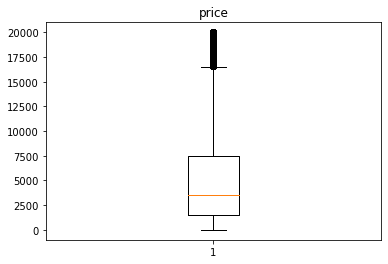

50000.0 225000.0


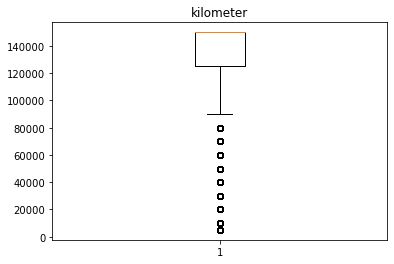

-150.0 375.0


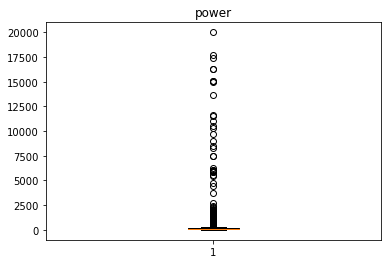

-11.0 45.0


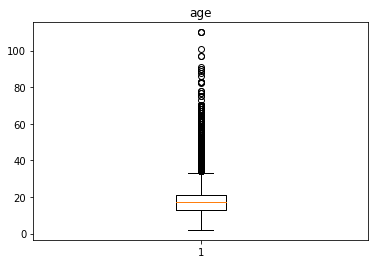

In [4]:
columns_anomaly_check = ['price', 'kilometer', 'power', 'age']


for column in columns_anomaly_check:
    Q1 = np.quantile(data[column] ,q = 0.25)
    Q3 = np.quantile(data[column] ,q = 0.75)
    
    IQR = Q3 - Q1 

    first_border = Q1 - 3 * IQR
    second_border = Q3 + 3 * IQR
    
    print(first_border, second_border)
    plt.title(column)
    plt.boxplot(data[column])
    plt.show()

    
    data[column] = data[(data[column] < second_border)&(data[column] > first_border)][column]


In [5]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226364 entries, 3 to 354367
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   price        226364 non-null  int64  
 1   vehicletype  226364 non-null  object 
 2   gearbox      226364 non-null  object 
 3   power        226364 non-null  float64
 4   model        226364 non-null  object 
 5   kilometer    226364 non-null  float64
 6   fueltype     226364 non-null  object 
 7   brand        226364 non-null  object 
 8   notrepaired  226364 non-null  object 
 9   age          226364 non-null  float64
dtypes: float64(3), int64(1), object(6)
memory usage: 19.0+ MB


In [6]:
target = data['price']
features = data.drop(['price'], axis=1)
target

3         1500
4         3600
5          650
6         2200
10        2000
          ... 
354360    3999
354362    3200
354363    1150
354366    1199
354367    9200
Name: price, Length: 226364, dtype: int64

In [7]:
encoder = OrdinalEncoder()
encoder.fit(features)
features = pd.DataFrame(encoder.transform(features), columns=features.columns)
features

,vehicletype,gearbox,power,model,kilometer,fueltype,brand,notrepaired,age
0,5.0,1.0,71.0,116.0,6.0,6.0,37.0,0.0,17.0
1,5.0,1.0,65.0,101.0,3.0,2.0,31.0,0.0,10.0
2,4.0,1.0,98.0,11.0,6.0,6.0,2.0,1.0,23.0
3,1.0,1.0,105.0,8.0,6.0,6.0,25.0,0.0,14.0
4,4.0,1.0,101.0,10.0,6.0,6.0,19.0,0.0,14.0
...,...,...,...,...,...,...,...,...,...
226359,7.0,1.0,3.0,11.0,6.0,2.0,2.0,0.0,13.0
226360,4.0,1.0,221.0,140.0,6.0,6.0,30.0,1.0,14.0
226361,0.0,1.0,0.0,248.0,6.0,6.0,24.0,0.0,18.0
226362,1.0,0.0,97.0,106.0,5.0,6.0,32.0,0.0,18.0


In [8]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25)


In [9]:
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(169773, 9) (169773,)
(56591, 9) (56591,)


Разделили данные 75/25 

## Обучение моделей

### Случайный лес.

In [10]:
parametrs_forest = {'n_estimators':[1, 250], 'max_depth':[1, 125]}
parametrs = {'n_estimators':[1, 5000], 'max_depth':[1, 2000]}

In [11]:
%%time

model = RandomForestRegressor(n_jobs=-1)
grid_model_forest = GridSearchCV(model, parametrs_forest, cv=5, n_jobs=-1)
grid_model_forest.fit(features_train, target_train)

grid_model_forest.best_params_

Wall time: 1min 21s


{'max_depth': 125, 'n_estimators': 250}

### LightGBM регрессор.

In [12]:
%%time
model = LGBMRegressor(n_jobs=-1)
grid_model = GridSearchCV(model, parametrs_forest, cv=5, n_jobs=-1)
grid_model.fit(features_train, target_train)
predict = grid_model.predict(features_test)

grid_model.best_params_

Wall time: 5.73 s


{'max_depth': 125, 'n_estimators': 250}

## Анализ моделей

### Время предсказания и качество предсказания рандомного леса:

In [13]:
%%time
predict = grid_model_forest.predict(features_test)
mean_squared_error(target_test, predict)**0.5

Wall time: 921 ms


1572.8568278374853

### Линейная регрессия качетсво/время

In [14]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)
predict = model.predict(features_test)
mean_squared_error(target_test, predict)**0.5

Wall time: 47 ms


2740.9960178979873

### Время предсказания и качество предсказания LightGBM регрессор:

In [15]:
%%time
predict = grid_model.predict(features_test)
mean_squared_error(target_test, predict)**0.5

Wall time: 121 ms


1563.5330321625877

## Вывод
Модель градиентного бустинга лучше справляется со своей задачей.
1. У нее быстрее скорость обучения чем у случайного(при одиннаковых гиперпараметрах). (1min 16s / 854 ms)
2. У нее быстрее скорость обработки запроса на предсказания. (854 ms / 96.1 ms)
3. И более высокая скорость предсказания. (1555.30 / 1549.35) <p> 
Так в свою очередь величина ошибка простой линейной регрессии нивелирует ее скорость обучения и предсказания.

## Увеличение гиперпараметров

In [16]:
%%time
model = LGBMRegressor(n_jobs=-1)
grid_model = GridSearchCV(model, parametrs, cv=5, n_jobs=-1)
grid_model.fit(features_train, target_train)
predict = grid_model.predict(features_test)

grid_model.best_params_

Wall time: 1min 50s


{'max_depth': 2000, 'n_estimators': 5000}

In [17]:
%%time
predict = grid_model.predict(features_test)
mean_squared_error(target_test, predict)**0.5

Wall time: 3.44 s


1496.8729942980226

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей